# Consumer Complaints

We'll use a database of complaints about consumer financial products and services to illustrate some aspects of how to work with unstructured information. The database is available [here](https://www.consumerfinance.gov/data-research/consumer-complaints/)

In [1]:
import pandas as pd
import numpy as np

import spacy

Import the data

In [2]:
file = 'Consumer_Complaints.csv.gz'

data = pd.read_csv(file,
                   delimiter=',')

### A first look at the structure of the data

In [3]:
data.head()

Date received           Product     Sub-product  \
0    03/12/2014          Mortgage  Other mortgage   
1    10/01/2016  Credit reporting             NaN   
2    10/17/2016     Consumer Loan    Vehicle loan   
3    06/08/2014       Credit card             NaN   
4    09/13/2014   Debt collection     Credit card   

                                      Issue                   Sub-issue  \
0  Loan modification,collection,foreclosure                         NaN   
1    Incorrect information on credit report              Account status   
2                Managing the loan or lease                         NaN   
3                                Bankruptcy                         NaN   
4                     Communication tactics  Frequent or repeated calls   

                        Consumer complaint narrative  \
0                                                NaN   
1  I have outdated information on my credit repor...   
2  I purchased a new car on XXXX XXXX. The car de...   
3                                                NaN   
4                                                NaN   

                             Company public response  \
0                                                NaN   
1  Company has responded to the consumer and the ...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

                                  Company State ZIP code            Tags  \
0                    M&T BANK CORPORATION    MI    48382             NaN   
1  TRANSUNION INTERMEDIATE HOLDINGS, INC.    AL    352XX             NaN   
2          CITIZENS FINANCIAL GROUP, INC.    PA    177XX  Older American   
3                AMERICAN EXPRESS COMPANY    ID    83854  Older American   
4                          CITIBANK, N.A.    VA    23233             NaN   

  Consumer consent provided? Submitted via Date sent to company  \
0                        NaN      Referral           03/17/2014   
1           Consent provided           Web           10/05/2016   
2           Consent provided           Web           10/20/2016   
3                        NaN           Web           06/10/2014   
4                        NaN           Web           09/13/2014   

  Company response to consumer Timely response? Consumer disputed?  \
0      Closed with explanation              Yes                 No   
1      Closed with explanation              Yes                 No   
2      Closed with explanation              Yes                 No   
3      Closed with explanation              Yes                Yes   
4      Closed with explanation              Yes                Yes   

   Complaint ID  
0        759217  
1       2141773  
2       2163100  
3        885638  
4       1027760

names and data types of columns

In [4]:
print(data.dtypes)

Date received                   object
Product                         object
Sub-product                     object
Issue                           object
Sub-issue                       object
Consumer complaint narrative    object
Company public response         object
Company                         object
State                           object
ZIP code                        object
Tags                            object
Consumer consent provided?      object
Submitted via                   object
Date sent to company            object
Company response to consumer    object
Timely response?                object
Consumer disputed?              object
Complaint ID                     int64
dtype: object


How many entries are missing in each column?

In [5]:
data.isnull().sum()

Date received                        0
Product                              0
Sub-product                     235170
Issue                                0
Sub-issue                       488682
Consumer complaint narrative    722317
Company public response         680977
Company                              0
State                            10892
ZIP code                         15051
Tags                            837232
Consumer consent provided?      526381
Submitted via                        0
Date sent to company                 0
Company response to consumer         1
Timely response?                     0
Consumer disputed?              203579
Complaint ID                         0
dtype: int64

since we will be working with the complaint narrative, let's remove the rows where it is missing

In [6]:
data = data[~data['Consumer complaint narrative'].isnull()]

In [7]:
# how many data points are missing where

data.isnull().sum()

Date received                        0
Product                              0
Sub-product                      52183
Issue                                0
Sub-issue                        94202
Consumer complaint narrative         0
Company public response         128528
Company                              0
State                              805
ZIP code                          2029
Tags                            207288
Consumer consent provided?           0
Submitted via                        0
Date sent to company                 0
Company response to consumer         0
Timely response?                     0
Consumer disputed?               85705
Complaint ID                         0
dtype: int64

In [8]:
data.shape

(249830, 18)

How many different products do we have and how often do they occur?

In [9]:
data['Product'].value_counts()

Debt collection                                                                 57324
Mortgage                                                                        41219
Credit reporting, credit repair services, or other personal consumer reports    37679
Credit reporting                                                                31593
Credit card                                                                     18842
Student loan                                                                    15495
Bank account or service                                                         14887
Consumer Loan                                                                    9473
Credit card or prepaid card                                                      7971
Checking or savings account                                                      4915
Vehicle loan or lease                                                            2065
Payday loan                                           

The last two occur very rarely, for simplicity we'll remove them in this first attempt

In [10]:
data = data[data['Product'] != 'Other financial service']
data = data[data['Product'] != 'Virtual currency']

In [11]:
data['Product'].value_counts()

Debt collection                                                                 57324
Mortgage                                                                        41219
Credit reporting, credit repair services, or other personal consumer reports    37679
Credit reporting                                                                31593
Credit card                                                                     18842
Student loan                                                                    15495
Bank account or service                                                         14887
Consumer Loan                                                                    9473
Credit card or prepaid card                                                      7971
Checking or savings account                                                      4915
Vehicle loan or lease                                                            2065
Payday loan                                           

It looks like some classes are contained in others. It probably makes sense to combine them

In [12]:
data.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfers': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)

In [13]:
data['Product'].value_counts()

Credit reporting, repair, or other                    69272
Debt collection                                       57324
Mortgage                                              41219
Credit card or prepaid card                           28263
Student loan                                          15495
Bank account or service                               14887
Consumer Loan                                          9473
Checking or savings account                            4915
Payday loan, title loan, or personal loan              3368
Money transfer, virtual currency, or money service     3240
Vehicle loan or lease                                  2065
Name: Product, dtype: int64

### First analysis of the Consumer complaint narrative

<Axes: >

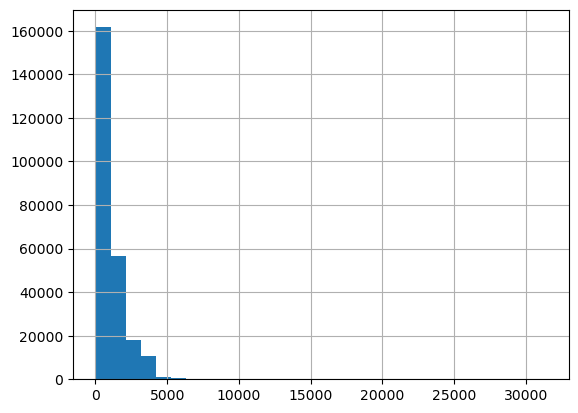

In [14]:
message_length = data['Consumer complaint narrative'].astype(str).apply(len)

message_length.hist(bins=30)


In [15]:
message_length.max()

31423

extract the narrative from the full data set

In [16]:
narrative = data['Consumer complaint narrative']

In [17]:
narrative.head()

1     I have outdated information on my credit repor...
2     I purchased a new car on XXXX XXXX. The car de...
7     An account on my credit report has a mistaken ...
12    This company refuses to provide me verificatio...
16    This complaint is in regards to Square Two Fin...
Name: Consumer complaint narrative, dtype: object

In [18]:
narrative.shape

(249521,)

We use spacy to tokenize, i.e. divide a sentence into words

In [19]:
from spacy.lang.en import English
parser = English()

In [20]:
def tokenize(text):
    tokens = [token.text for token in parser(text)] 
    return tokens

In [21]:
print(tokenize(narrative[1]))

['I', 'have', 'outdated', 'information', 'on', 'my', 'credit', 'report', 'that', 'I', 'have', 'previously', 'disputed', 'that', 'has', 'yet', 'to', 'be', 'removed', 'this', 'information', 'is', 'more', 'then', 'seven', 'years', 'old', 'and', 'does', 'not', 'meet', 'credit', 'reporting', 'requirements']


To extract the root form of each word we use nltk's wordnet and the lemmatizer

In [22]:
import nltk
nltk.download('wordnet')

from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

from nltk.stem import SnowballStemmer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mpluemacher/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


remove stop words as they contain no information

In [23]:
nltk.download('omw-1.4')
nltk.download('stopwords')
#en_stop = set(nltk.corpus.stopwords.words('english'))

en_stop = nltk.corpus.stopwords.words('english')

newStopWords = \
    ['', 'com', 'de', 'eu', 'cf', 'pm', 'like', 'one', 'using', 'new', 'also',
     'really', 'need', 'caption', 'since', 'change', 'young', 'align', 'width',
     'attachment', 'number', 'know', 'two', 'use', 'see', 'get', 'first', 'good',
     'next', 'well', 'day', 'way', 'different', 'let', 'lot', 'would',
     'already', 'set', 'user', 'even', 'might', 'many', 'different', 'crazy',
     'may', 'could', 'still', 'probably', 'make', 'write', 'used', 'written',
     'go', 'us', 'yes', 'seen', 'behind', 'much', 'makes', 'via', 'based',
     'choose', 'presented', 'away', 'hence', 'wants', 'please', 'add',
     'something', 'conclusion', 'able', 'describe', 'thing', 'likely',
     'lots', 'sense', 'higher', 'every', 'right', 'sure', 'quite', 'without',
     'within', 'follow', 'look', 'example', 'examples', 'short',
     'cancel', 'promise', 'means', 'almost', 'large', 'besides']

en_stop.extend(newStopWords)

snowball_stemmer = SnowballStemmer('english')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mpluemacher/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mpluemacher/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The following function will be used to preprocess each complaint narrative

In [24]:
def clean_text(text):
    text = text.lower()
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    tokens = [snowball_stemmer.stem(token) for token in tokens]
    return tokens

In [25]:
clean_text(narrative[1])

['outdat',
 'inform',
 'credit',
 'report',
 'previous',
 'disput',
 'remov',
 'inform',
 'seven',
 'year',
 'credit',
 'report',
 'requir']

In [26]:
text_data = narrative.apply(clean_text)

In [27]:
text_data

1         [outdat, inform, credit, report, previous, dis...
2         [purchas, dealer, call, citizen, payoff, deale...
7         [account, credit, report, mistak, mail, valid,...
12        [compani, refus, provid, verif, valid, fdcpa, ...
16        [complaint, regard, squar, financi, refer, reg...
                                ...                        
972139    [take, visit, insur, hospit, fail, submit, cla...
972140    [xxxx/13, author, america, withdraw, 29000.00,...
972143    [account, previous, disput, tower, employ, fat...
972144    [contact, email, calib, loan, refin, current, ...
972146    [debit, includ, chapter, year, letter, show, c...
Name: Consumer complaint narrative, Length: 249521, dtype: object

### First classification attempt

As a simple and quick start we use Latent Dirichlet Allocation (LDA) with gensim using a simplistic bag-of-words approach

In [28]:
from gensim import corpora

dictionary = corpora.Dictionary(text_data)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in text_data]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of messages: %d' % len(corpus))


import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

Number of unique tokens: 7131
Number of messages: 249521


a brief look at word frequencies

In [29]:
# Count word frequencies
from collections import defaultdict
frequency = defaultdict(int)
for text in text_data:
    for token in text:
        frequency[token] += 1
        
frequencySorted=dict(sorted(frequency.items(), key=lambda x: x[1],reverse=True))


In [30]:
frequencySorted

{'credit': 366484,
 'account': 359969,
 'report': 274410,
 'payment': 261496,
 'inform': 177411,
 'receiv': 162455,
 'call': 159003,
 'month': 128651,
 'compani': 126861,
 'state': 108032,
 'letter': 105944,
 'request': 103859,
 'collect': 101712,
 'never': 98254,
 'mortgag': 97737,
 'charg': 96325,
 'contact': 95682,
 'servic': 94571,
 'check': 88037,
 'disput': 83559,
 'amount': 82160,
 'ask': 81625,
 'provid': 77649,
 'phone': 74203,
 'remov': 73928,
 'document': 69694,
 'money': 69618,
 'balanc': 67525,
 'close': 62696,
 'year': 59193,
 'interest': 58199,
 'tri': 57554,
 'issu': 56831,
 'agenc': 53403,
 'time': 50271,
 'person': 49865,
 'complaint': 49005,
 'address': 47538,
 'statement': 47453,
 'bureau': 45670,
 'claim': 45569,
 'custom': 45141,
 'file': 43916,
 'consum': 43318,
 'email': 43277,
 'continu': 43197,
 'refus': 43180,
 'respons': 43172,
 'show': 42215,
 'process': 42202,
 'loan': 41103,
 'notic': 40801,
 'anoth': 40085,
 'sever': 39833,
 'appli': 39187,
 'repres': 39

LDA will now attempt to find 11 topics in the complaint narratives

In [31]:
import gensim

# Set training parameters.
num_topics = 11
workers = 8
passes = 1

id2word = dictionary

ldamodel = gensim.models.LdaMulticore(
    corpus=corpus,
    id2word=id2word,
    num_topics=num_topics,
    workers=workers,
    passes=passes
)


ldamodel.save('model5.gensim')

topics = ldamodel.print_topics(num_words=6)

for topic in topics:
    print(topic)

(0, '0.027*"mortgag" + 0.014*"modif" + 0.013*"document" + 0.012*"payment" + 0.011*"receiv" + 0.010*"month"')
(1, '0.065*"account" + 0.023*"check" + 0.021*"money" + 0.017*"call" + 0.013*"charg" + 0.010*"fund"')
(2, '0.030*"payment" + 0.023*"receiv" + 0.016*"call" + 0.013*"inform" + 0.013*"letter" + 0.012*"amount"')
(3, '0.060*"report" + 0.026*"remov" + 0.026*"inquiri" + 0.018*"account" + 0.013*"score" + 0.012*"never"')
(4, '0.021*"charg" + 0.019*"chase" + 0.017*"servic" + 0.016*"receiv" + 0.014*"call" + 0.012*"inform"')
(5, '0.020*"insur" + 0.014*"escrow" + 0.014*"collect" + 0.013*"request" + 0.012*"provid" + 0.011*"letter"')
(6, '0.030*"call" + 0.026*"collect" + 0.024*"compani" + 0.016*"receiv" + 0.015*"phone" + 0.013*"state"')
(7, '0.068*"report" + 0.052*"account" + 0.033*"inform" + 0.021*"disput" + 0.014*"request" + 0.012*"letter"')
(8, '0.026*"account" + 0.022*"well" + 0.022*"fargo" + 0.019*"check" + 0.014*"receiv" + 0.011*"call"')
(9, '0.035*"loan" + 0.022*"student" + 0.019*"navien

Interactive visualization of the topics identified by LDA

In [32]:
import pyLDAvis.gensim_models

lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary, sort_topics=False, n_jobs=1)
pyLDAvis.display(lda_display)

pyLDAvis.save_html(lda_display, 'lda.html')

/Users/mpluemacher/anaconda3/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1841: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


### Supervised learning model based on Product and complaint narrative

In [33]:
data2 = data[['Product', 'Consumer complaint narrative']].copy()

In [34]:
data2.head()

Product  \
1   Credit reporting, repair, or other   
2                        Consumer Loan   
7   Credit reporting, repair, or other   
12                     Debt collection   
16                     Debt collection   

                         Consumer complaint narrative  
1   I have outdated information on my credit repor...  
2   I purchased a new car on XXXX XXXX. The car de...  
7   An account on my credit report has a mistaken ...  
12  This company refuses to provide me verificatio...  
16  This complaint is in regards to Square Two Fin...

In [35]:
data2.shape

(249521, 2)

In [36]:
X = data2['Consumer complaint narrative']
y = data2['Product']

from sklearn.model_selection import train_test_split

split into training and test data

In [37]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0, stratify=y)

transform each complaint into a tf-idf vector, using words and bigrams

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

ngram_range = (1,2)
min_df = 100
max_df = 1.
max_features = 5000

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=min_df, max_df=max_df, max_features=max_features,
                        norm='l2', encoding='latin-1', ngram_range=ngram_range, stop_words='english')

# fit vectorizer to training data only
X_train = tfidf.fit_transform(X_train).toarray()

# vectorize test data
X_test = tfidf.transform(X_test).toarray()

In [39]:
y_train.head()

11266                    Student loan
807002    Credit card or prepaid card
279239                       Mortgage
954831                       Mortgage
495218                       Mortgage
Name: Product, dtype: object

simplest first model: Support Vector Classifier based on stochastic gradient descent

In [40]:
#from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import joblib

#model = LinearSVC()
model = SGDClassifier(loss='hinge', alpha=1e-06)

model.fit(X_train, y_train)

# save model to disk
joblib.dump(model, 'CustomerComplaintsClassifier.model')

['CustomerComplaintsClassifier.model']

test the model on test data

In [41]:
y_pred = model.predict(X_test)

# get the accuracy

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

0.8261697224726982


accuracy score can be misleading for unbalanced classes, let's look at the confusion matrix 

/var/folders/c4/kpbv1lzn3xjd4jhn2m5pz3_h0000gn/T/ipykernel_21520/2591409608.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
/var/folders/c4/kpbv1lzn3xjd4jhn2m5pz3_h0000gn/T/ipykernel_21520/2591409608.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
/var/folders/c4/kpbv1lzn3xjd4jhn2m5pz3_h0000gn/T/ipykernel_21520/2591409608.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


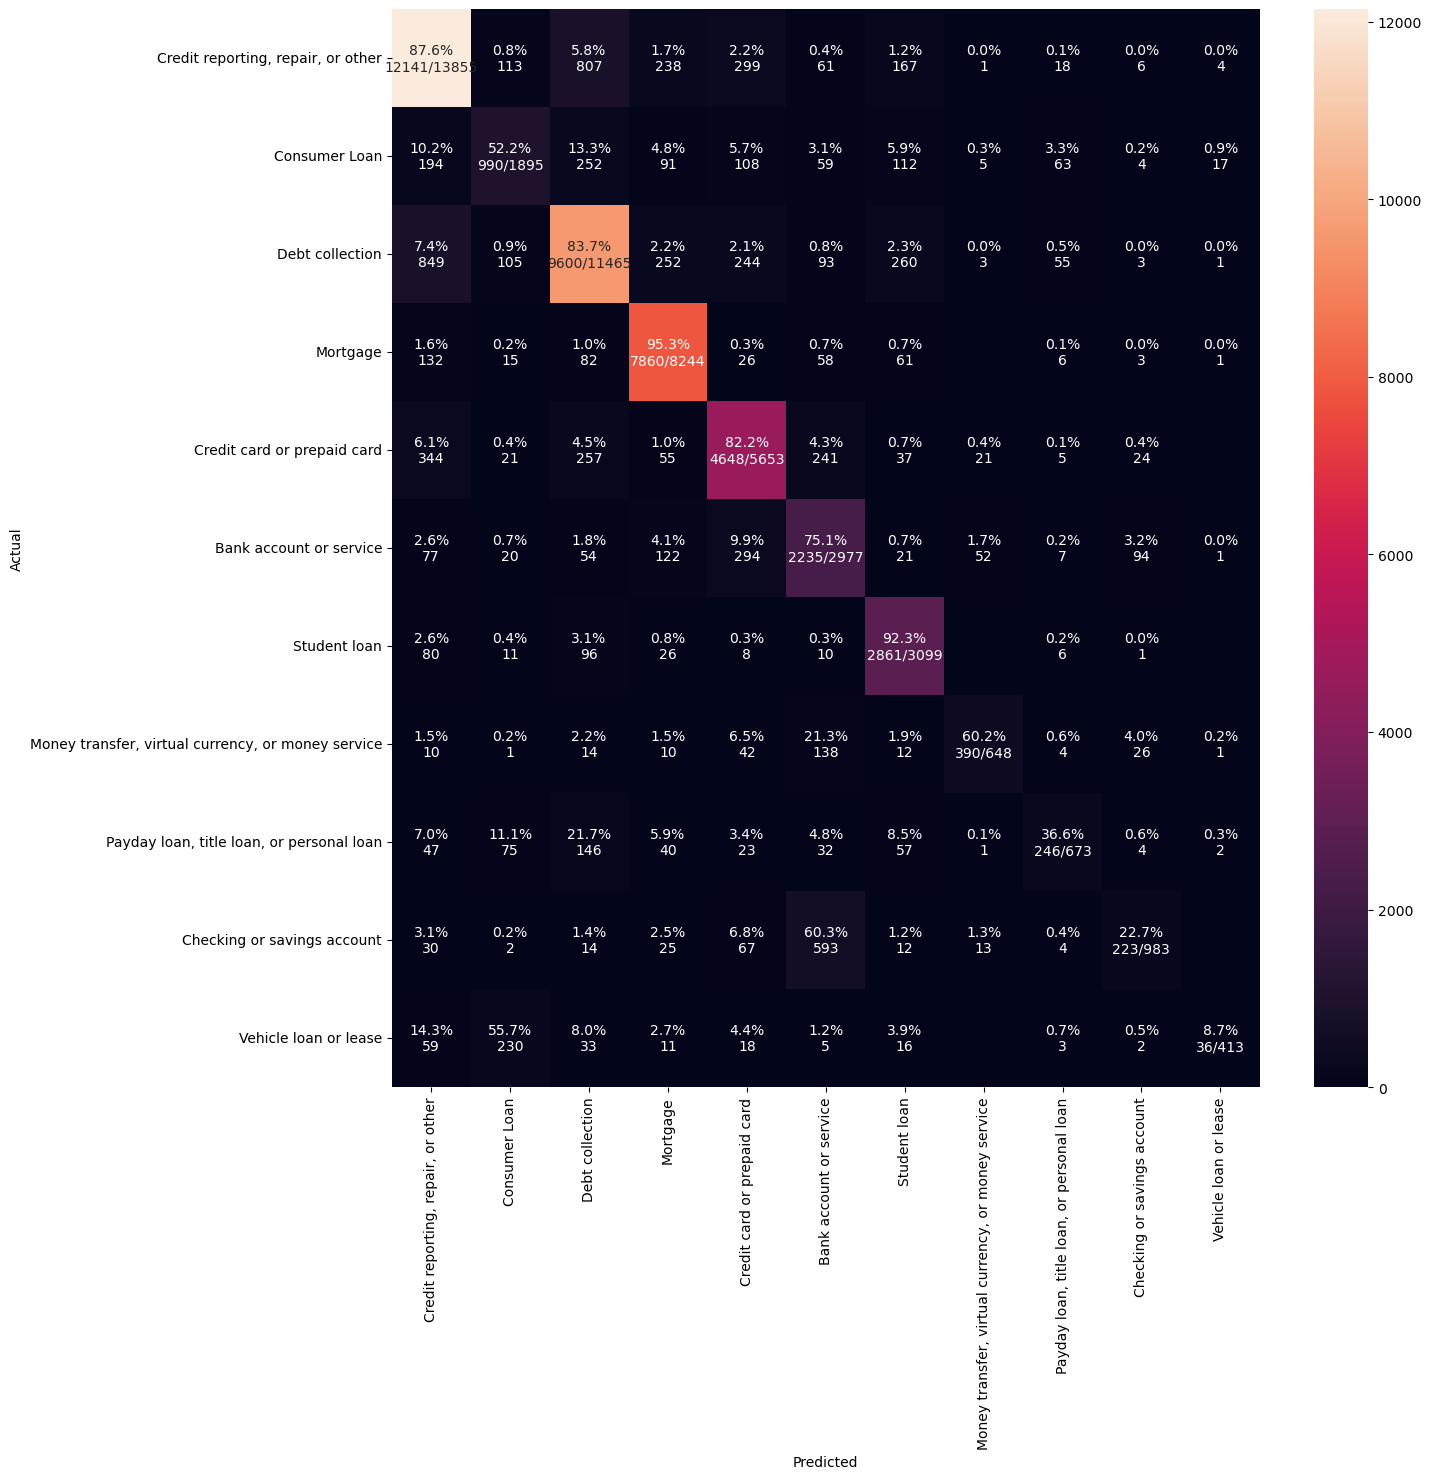

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig('ConfusionMatrix.png')
    plt.show()

labels = y.unique().tolist()    

cm_analysis(y_test, y_pred, labels, ymap=None, figsize=(14,14))